# Load data from Smart-Kages
The data will be loaded from DLC .h5 pose files into `movement` datasets.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from movement.filtering import filter_by_confidence
from movement.io import load_poses
from movement.kinematics import compute_pairwise_distances, compute_speed
from movement.plots import plot_centroid_trajectory, plot_occupancy
from movement.transforms import scale

from smart_kages_movement.io import load_background_frame

In [2]:
FPS = 2.0  # Frames per second
PIXELS_PER_CM = 10  # Pixels per cm

sns.set_context("notebook")

In [3]:
data_dir = Path.home() / "Data" / "Smart-Kages"
analysis_dir = data_dir / "movement_analysis"
timestamps_dir = analysis_dir / "timestamps"
df_path = analysis_dir / "dlc_files.csv"

for path in [data_dir, analysis_dir, timestamps_dir, df_path]:
    if not path.exists():
        print(f"Path does not exist: {path}")

In [4]:
df = pd.read_csv(
    df_path, index_col=[0, 1, 2], dtype={"date": str, "hour": str}
)
df.head()

start_datetime  \
kage  date     hour                        
kage1 20240403 09    2024-04-03 09:54:24   
               10    2024-04-03 10:00:06   
               11    2024-04-03 11:01:07   
               12    2024-04-03 12:01:08   
               13    2024-04-03 13:01:07   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                     video_exists  \
kage  date     hour                 
kage1 20240403 09            True   
               10            True   
               11            True   
               12            True   
               13            True   

                                                       video_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   

                     n_frames  height  width  n_channels  n_timestamps  \
kage  date     hour                                                      
kage1 20240403 09         665     376    500           3           665   
               10        7183     376    500           3          7183   
               11        7064     376    500           1          7064   
               12        7059     376    500           3          7059   
               13        7058     376    500           3          7058   

                                                  timestamps_file_path  
kage  date     hour                                                     
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               10    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               11    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               12    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
               13    /Users/nsirmpilatze/Data/Smart-Kages/movement_...

In [5]:
# Let's focus on a single kage
kage = "kage3"

df_kage = df.loc[kage]
n_days = df_kage.index.get_level_values("date").nunique()
print(f"Number of days for {kage}: {n_days}")
n_segments = df_kage.shape[0]
print(f"Number of 1-hour segments for {kage}: {n_segments}")
# Sort by the index to ensure chronological order
df_kage = df_kage.sort_index()
df_kage.head()

Number of days for kage3: 39
Number of 1-hour segments for kage3: 855


start_datetime  \
date     hour                        
20240402 17    2024-04-02 17:03:26   
         18    2024-04-02 18:01:07   
         19    2024-04-02 19:01:07   
         20    2024-04-02 20:01:08   
         21    2024-04-02 21:01:07   

                                                  pose_file_path  \
date     hour                                                      
20240402 17    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
         18    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
         19    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
         20    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
         21    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   

               video_exists  \
date     hour                 
20240402 17            True   
         18            True   
         19            True   
         20            True   
         21            True   

                                                 video_file_path  n_frames  \
date     hour                                                                
20240402 17    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...      6767   
         18    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...      7058   
         19    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...      7046   
         20    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...      7061   
         21    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...      7062   

               height  width  n_channels  n_timestamps  \
date     hour                                            
20240402 17       376    500           3          6767   
         18       376    500           3          7058   
         19       376    500           3          7046   
         20       376    500           3          7061   
         21       376    500           3          7062   

                                            timestamps_file_path  
date     hour                                                     
20240402 17    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
         18    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
         19    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
         20    /Users/nsirmpilatze/Data/Smart-Kages/movement_...  
         21    /Users/nsirmpilatze/Data/Smart-Kages/movement_...

In [6]:
def is_monotonic_increasing(arr):
    return (arr[1:] >= arr[:-1]).all()

In [7]:
# Let's load the data into `movement`
ds_kage_list = []

kage_start_datetime = pd.Timestamp(df_kage["start_datetime"].iloc[0])
previous_segment_end_datetime = kage_start_datetime

for date, hour in df_kage.index:
    # Load the pose data for the current kage
    pose_file_path = df_kage.loc[(date, hour), "pose_file_path"]
    poses = load_poses.from_file(
        pose_file_path, source_software="DeepLabCut", fps=FPS
    )

    # Create a seconds_since_start array for this segment
    segment_start_datetime = pd.Timestamp(
        df_kage.loc[(date, hour), "start_datetime"]
    )

    # Load timestamps for the current hour segment
    timestamps = pd.read_csv(
        timestamps_dir / f"{kage}_{date}_{hour}_timestamps.txt",
        names=["datetime"],
    ).astype({"datetime": "datetime64[ns]"})
    timestamps = timestamps["datetime"].values

    # assign primary time coordinate as the actual datetime timestamps
    poses = poses.assign_coords(time=timestamps)
    poses.attrs["time_unit"] = "datetime64[ns]"

    if segment_start_datetime <= previous_segment_end_datetime:
        print(
            "Warning: \n"
            f"Segment starts before the previous segment ends: "
            f"{segment_start_datetime} < {previous_segment_end_datetime}. "
            "The overlapping part of the current segment will be discarded."
        )
        # Discard the part of this segment that overlaps the previous one
        poses = poses.sel(time=slice(previous_segment_end_datetime, None))

    previous_segment_end_datetime = timestamps[-1]

    # Let's get rid of the "individuals" dimension (it's always 1)
    if "individuals" in poses.dims:
        poses = poses.drop_vars("individuals").squeeze("individuals")

    # add to list
    ds_kage_list.append(poses)

# Combine all segments into a single xarray Dataset
ds_kage = xr.concat(ds_kage_list, dim="time")
ds_kage.attrs["kage_start_datetime"] = kage_start_datetime.isoformat()

# Ensure the timestamps of the concatenated dataset are monotonic increasing
assert is_monotonic_increasing(ds_kage.time.values), (
    f"Timestamps are not monotonic increasing for {kage}!"
)

# Assign secondary time coordinate as seconds elapsed since kage start
# Calculate seconds elapsed since kage start datetime
seconds_since_kage_start = (
    ds_kage.time.data - np.datetime64(kage_start_datetime)
).astype("timedelta64[ms]").astype(float) * 0.001

ds_kage = ds_kage.assign_coords(
    seconds_since_start=("time", seconds_since_kage_start)
)
ds_kage

Segment starts before the previous segment ends: 2024-04-02 17:03:26 < 2024-04-02 17:03:26. The overlapping part of the current segment will be discarded.
Segment starts before the previous segment ends: 2024-04-04 05:01:08 < 2024-04-04T05:20:13.500562436. The overlapping part of the current segment will be discarded.
Segment starts before the previous segment ends: 2024-04-22 08:00:06 < 2024-04-22T08:18:11.498755925. The overlapping part of the current segment will be discarded.
Segment starts before the previous segment ends: 2024-04-23 08:00:06 < 2024-04-23T08:18:11.493296687. The overlapping part of the current segment will be discarded.
Segment starts before the previous segment ends: 2024-04-25 06:21:21 < 2024-04-25T06:59:59.497929555. The overlapping part of the current segment will be discarded.
Segment starts before the previous segment ends: 2024-05-04 06:21:21 < 2024-05-04T06:59:59.498561083. The overlapping part of the current segment will be discarded.
Segment starts befor

<xarray.Dataset> Size: 1GB
Dimensions:              (time: 6073880, space: 2, keypoints: 8)
Coordinates:
  * space                (space) <U1 8B 'x' 'y'
  * keypoints            (keypoints) <U10 320B 'snout' 'leftear' ... 'tailbase'
  * time                 (time) datetime64[ns] 49MB 2024-04-02T17:03:26 ... 2...
    seconds_since_start  (time) float64 49MB 0.0 0.501 ... 3.254e+06 3.254e+06
Data variables:
    position             (time, space, keypoints) float64 777MB 464.5 ... 2.151
    confidence           (time, keypoints) float64 389MB 0.9944 1.0 ... 0.06425
Attributes:
    source_software:      DeepLabCut
    ds_type:              poses
    fps:                  2.0
    time_unit:            datetime64[ns]
    source_file:          /Users/nsirmpilatze/Data/Smart-Kages/kage3/analysis...
    kage_start_datetime:  2024-04-02T17:03:26

Text(0.5, 0.98, 'Confidence Histograms for kage3')

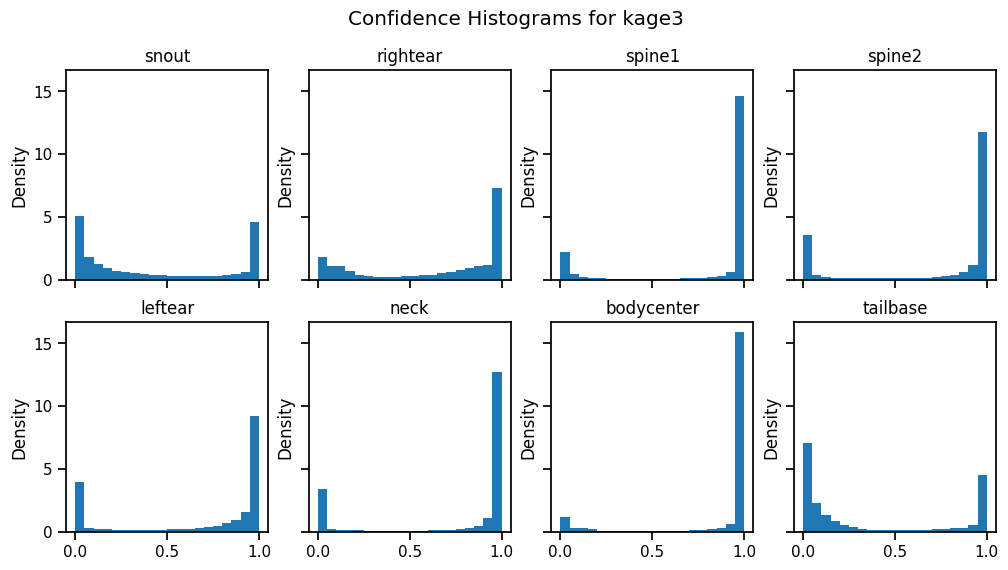

In [8]:
# Let's plot confidence histograms for each keypoint
n_keypoints = ds_kage.sizes["keypoints"]
fig, axes = plt.subplots(
    nrows=2,
    ncols=(n_keypoints + 1) // 2,
    figsize=(12, 6),
    sharey=True,
    sharex=True,
)

for i, kpt in enumerate(ds_kage.keypoints.values):
    ax = axes[i % 2, i // 2]
    ds_kage.confidence.sel(keypoints=kpt).plot.hist(
        bins=20,
        ax=ax,
        label=kpt,
        histtype="stepfilled",
        density=True,
    )
    ax.set_ylabel("Density")
    ax.set_xlabel("")
    ax.set_title(kpt)
plt.suptitle(f"Confidence Histograms for {kage}")

In [9]:
use_keypoints = ["spine1", "bodycenter", "spine2", "tailbase"]

ds_kage["position_filtered"] = filter_by_confidence(
    ds_kage.position, ds_kage.confidence, threshold=0.9
)

In [10]:
median_body_length = (
    compute_pairwise_distances(
        ds_kage.position_filtered, dim="keypoints", pairs={"snout": "tailbase"}
    )
    .median()
    .values
)
print(
    f"Median body length for {kage} on {date}: {median_body_length:.2f} pixels"
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Median body length for kage3 on 20240510: 61.32 pixels


In [11]:
# dataset indexed by seconds since start
ds_kage_sec = ds_kage.set_index(time="seconds_since_start")

ds_kage_sec["speed_body_lengths"] = compute_speed(
    scale(
        ds_kage_sec.position_filtered,
        factor=1 / median_body_length,
        space_unit="body_length",
    )
)

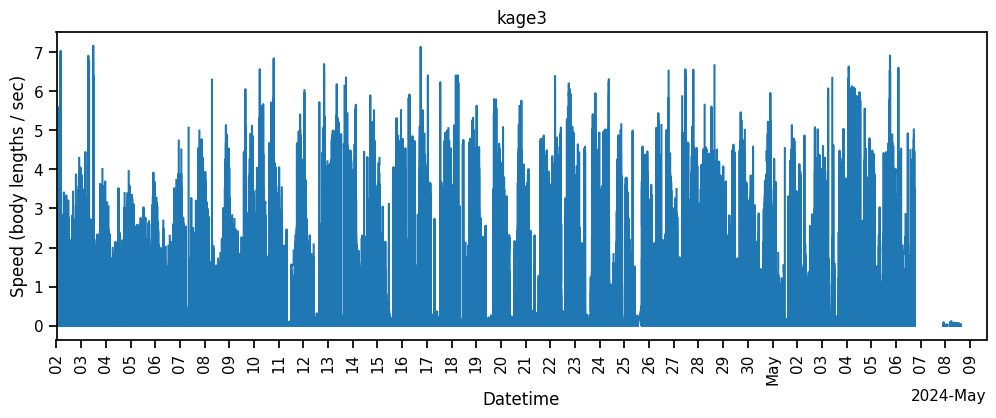

In [21]:
# switch back to datetime for plotting
ds_kage_dt = ds_kage_sec.assign_coords(
    time=ds_kage.time.astype("datetime64[ns]")
)

fig, ax = plt.subplots(figsize=(12, 4))
ds_kage_dt["speed_body_lengths"].sel(keypoints="bodycenter").plot.line(
    x="time", ax=ax
)
ax.set_title(kage)
ax.set_ylabel("Speed (body lengths / sec)")
ax.set_xlabel("Datetime")
ax.set_xlim(
    ds_kage_dt.time.min().values,
    ds_kage_dt.time.max().values,
)
# set x-ticks to every day
plt.xticks(
    pd.date_range(
        start=ds_kage_dt.time.min().values,
        end=ds_kage_dt.time.max().values,
        freq="1D",
    ),
    rotation=90,
);

In [18]:
background_img = load_background_frame(
    video_path=df_kage.iloc[0]["video_file_path"], i=0, n_average=100
)
height, width = background_img.shape[:2]

2025-05-27 22:13:33.459 | WARNING  | matplotlib._api:warn_external:391 - /var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipykernel_1580/2216924668.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(



(0.0, 500.0)

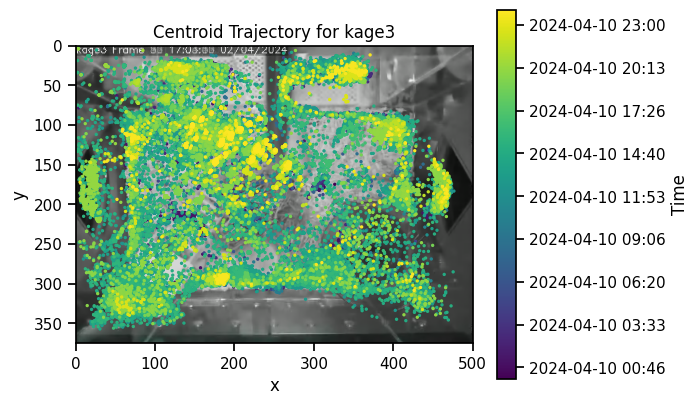

In [26]:
time_window = slice("2024-04-10T00:00:00", "2024-04-11T00:00:00")

fig, ax = plt.subplots()
ax.imshow(background_img)
plot_centroid_trajectory(ds_kage_dt.sel(time=time_window).position, ax=ax, s=2)
# Get the colorbar ticks from the ax and format them as timestamps
cbar = ax.collections[0].colorbar
current_ticks = cbar.get_ticks()
cbar.set_ticklabels(
    [pd.Timestamp(t).strftime("%Y-%m-%d %H:%M") for t in current_ticks]
)
ax.set_title(f"Centroid Trajectory for {kage}")
ax.set_ylim([height - 1, 0])
ax.set_xlim([0, width])

Text(0.5, 1.0, 'Body occupancy (log scale)')

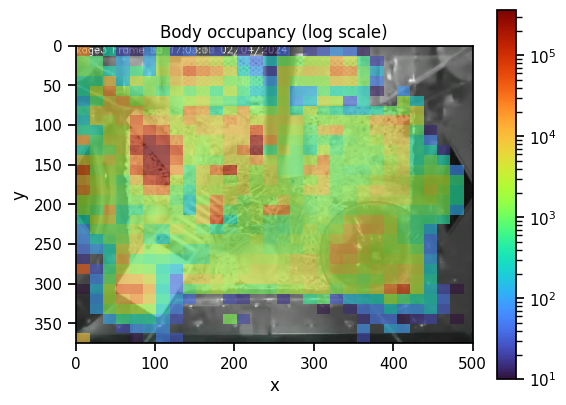

In [27]:
fig, ax = plt.subplots()
ax.imshow(background_img)
plot_occupancy(
    ds_kage.position,
    # conside the centroid of the following keypoints
    keypoints=use_keypoints,
    ax=ax,
    cmap="turbo",
    norm="log",  # log scale the colormap
    cmin=10,  # only show occupancy above 1 frame
    alpha=0.6,  # some transparency
)
# invert y-axis to match the video frame
ax.set_ylim([height - 1, 0])
ax.set_xlim([0, width])
ax.set_title("Body occupancy (log scale)")